# Importing request

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import numpy as np
from config import api_key
from config import api_id
from config import api_key2

# Creating random list for MSAs
Keith wrote the code to generate the random list from the top polluting MSAs

In [2]:
# The data to load
f = "../data/msa.csv"

# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - retrieving header and 5 MSA's
size = 10

# The row indices to skip - make sure 0 is not included to keep the header
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
msa = pd.read_csv(f, skiprows=skip_idx)

# Display the sample
msa


,MSA
0,"Chicago-Naperville, IL-IN-WI"
1,"Cincinnati-Wilmington-Maysville, OH-KY-IN"
2,"Cleveland-Akron-Canton, OH"
3,"Detroit-Warren-Ann Arbor, MI"
4,"Houston-The Woodlands, TX"
5,"Los Angeles-Long Beach, CA"
6,"Philadelphia-Reading-Camden, PA-NJ-DE-MD"
7,"Sacramento-Roseville, CA"
8,"Shreveport-Bossier City-Minden, LA"


# Striping Leading/Trailing Spaces for Merge

In [3]:
msa['MSA1']=msa['MSA'].str.strip()
msa

,MSA,MSA1
0,"Chicago-Naperville, IL-IN-WI","Chicago-Naperville, IL-IN-WI"
1,"Cincinnati-Wilmington-Maysville, OH-KY-IN","Cincinnati-Wilmington-Maysville, OH-KY-IN"
2,"Cleveland-Akron-Canton, OH","Cleveland-Akron-Canton, OH"
3,"Detroit-Warren-Ann Arbor, MI","Detroit-Warren-Ann Arbor, MI"
4,"Houston-The Woodlands, TX","Houston-The Woodlands, TX"
5,"Los Angeles-Long Beach, CA","Los Angeles-Long Beach, CA"
6,"Philadelphia-Reading-Camden, PA-NJ-DE-MD","Philadelphia-Reading-Camden, PA-NJ-DE-MD"
7,"Sacramento-Roseville, CA","Sacramento-Roseville, CA"
8,"Shreveport-Bossier City-Minden, LA","Shreveport-Bossier City-Minden, LA"


# Reading in MSA Crosswalk info for MSA codes

In [4]:
file = "../data/msa_crosswalk.csv"
crosswalk = pd.read_csv(file)
crosswalk1 = crosswalk[['CBSA Code','CSA Title']].sort_values('CSA Title',ascending = False).rename(columns = {'CSA Title':'MSA1'}).dropna().drop_duplicates()
crosswalk1.head()

,CBSA Code,MSA1
1503,41400,"Youngstown-Warren, OH-PA"
1893,49660,"Youngstown-Warren, OH-PA"
1865,48700,"Williamsport-Lock Haven, PA"
974,30820,"Williamsport-Lock Haven, PA"
1860,48620,"Wichita-Arkansas City-Winfield, KS"


# Joining MSA Crosswalk to Top MSAs to get the CBSA Codes needed for API Pulls

In [5]:
msa_codes = pd.merge(crosswalk1,msa,
                how = 'inner',
                on = 'MSA1')

print(msa_codes.head())
print('-----------------------------------------------------------------------')
print("There are multiple CBSA Codes per MSA, there were " + str(len(msa)) +" codes before join and  "+ str(len(msa_codes)) +" CBSA codes after the join.")

  CBSA Code                                      MSA1  \
0     40900                  Sacramento-Roseville, CA   
1     46020                  Sacramento-Roseville, CA   
2     49700                  Sacramento-Roseville, CA   
3     37980  Philadelphia-Reading-Camden, PA-NJ-DE-MD   
4     36140  Philadelphia-Reading-Camden, PA-NJ-DE-MD   

                                         MSA  
0                   Sacramento-Roseville, CA  
1                   Sacramento-Roseville, CA  
2                   Sacramento-Roseville, CA  
3   Philadelphia-Reading-Camden, PA-NJ-DE-MD  
4   Philadelphia-Reading-Camden, PA-NJ-DE-MD  
-----------------------------------------------------------------------
There are multiple CBSA Codes per MSA, there were 9 codes before join and  36 CBSA codes after the join.


# API Call - Pollution Part 1
using a for loop to loop through three years work of PM2.5 data

In [7]:
response_sample = []
start = ["20140101","20130101","20120101"]
end = ["20141231","20131231","20121231"]
codes = msa_codes['CBSA Code']


for index in range(len(start)):
    for each_msa in codes:
        try:
            url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
            response_sample.append(requests.get(url).json())
        except:
            print(f'MSA {each_msa} not found')

In [8]:
len(response_sample)

108

# Pulling Data and putting in list
There are two loops, the first loop is through the 33 different MSAs. Unfortunately the EPA does not always sample every 3 dyas like their website says. This leads to certain sampling sites having different lengths of samples. The second loop goes from 0 to the length of the number of samples they do have

In [10]:
time = []
date = []
cbsa_code = []
site = []
sample = []


for x in range(len(response_sample)):
# for x in range(0,32):
    for y in range(0,response_sample[x]['Header'][0]['rows']):
        time.append(response_sample[x]['Data'][y]['time_local'])
        date.append(response_sample[x]['Data'][y]['date_local'])
        cbsa_code.append(response_sample[x]['Data'][y]['cbsa_code'])
        site.append(response_sample[x]['Data'][y]['site_number'])
        sample.append(response_sample[x]['Data'][y]['sample_measurement'])

columns = ['time','date','cbsa_code','site','sample']
df_sample = pd.DataFrame(data = list(zip(time,date,cbsa_code,site,sample)), columns = columns)

df_sample.head()

,time,date,cbsa_code,site,sample
0,00:00,2014-01-05,40900,1003,6.1
1,00:00,2014-01-11,40900,1003,11.5
2,00:00,2014-01-17,40900,1003,NaN
3,00:00,2014-01-22,40900,1003,12.0
4,00:00,2014-01-23,40900,1003,NaN


# Converting date to DateTime
needed to group by month which is format that Oil Data is in

In [11]:
df_sample['date'] = pd.to_datetime(df_sample.date,format = '%Y-%m')
df_sample['year'] = pd.to_datetime(df_sample.date,format = '%Y-%m').dt.year
print(df_sample.head(1))
print('---------------------------------------------------------')
print("There are "+ str(len(df_sample)) +" rows of PM2.5 data")

    time       date cbsa_code  site  sample  year
0  00:00 2014-01-05     40900  1003     6.1  2014
---------------------------------------------------------
There are 734516 rows of PM2.5 data


In [12]:
df_sample['month_year'] = df_sample['date'].dt.strftime('%m-%Y')
df_sample['year'] = df_sample['year'].astype(str)
df_sample.head(1)

,time,date,cbsa_code,site,sample,year,month_year
0,00:00,2014-01-05,40900,1003,6.1,2014,01-2014


converting sample to float to be used for regression/analysis later

In [13]:
df_sample= df_sample.astype({'sample': float})

# Grouping Hourly Data by day & Merging
PM2.5 data is organized by hour, but we need it on a daily level so it can map in with the AQI levels. First we do a groupby to get daily levels, then we need to remerge with the original data to get the categorical data back in (county, site, lat, lon)

In [14]:
df_sample1 = df_sample[['site','sample','month_year','cbsa_code','year']].groupby(['month_year','cbsa_code','site','year']).mean().reset_index().sort_values('month_year',ascending = False)
df_sample1.head()
print(df_sample1.head(3))
print('-----------------------------------------')
print('There are '+ str(len(df_sample1)) + ' rows after grouping')

     month_year cbsa_code  site  year    sample
4385    12-2014     49700  0003  2014  7.270000
4293    12-2014     16980  4201  2014  9.781818
4296    12-2014     17140  0006  2014  9.310000
-----------------------------------------
There are 4386 rows after grouping


# Creating Dummy Variables for Time and Sites

In [15]:
sample1 = pd.get_dummies(df_sample1[['month_year']])
sample1.head()

,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,month_year_03-2012,month_year_03-2013,month_year_03-2014,month_year_04-2012,...,month_year_09-2014,month_year_10-2012,month_year_10-2013,month_year_10-2014,month_year_11-2012,month_year_11-2013,month_year_11-2014,month_year_12-2012,month_year_12-2013,month_year_12-2014
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Merging Dummy Variables Back In

In [16]:
sample2 = pd.concat([df_sample1,sample1],axis = 1).dropna()
sample2.head(2)

,month_year,cbsa_code,site,year,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,...,month_year_09-2014,month_year_10-2012,month_year_10-2013,month_year_10-2014,month_year_11-2012,month_year_11-2013,month_year_11-2014,month_year_12-2012,month_year_12-2013,month_year_12-2014
4385,12-2014,49700,0003,2014,7.270000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4293,12-2014,16980,4201,2014,9.781818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# API Call Census Data
pulling on 5 polluted state/counties from random selection of the top 20 highest polluted counties in the US

pulling sectors for mining/quarring, utilities, construction, manufactoring, & wholesale trade

https://classcodes.com/naics-2-digit-sector-codes/

In [17]:
year_survey = ['2016','2015','2014']
year_actual = ['2014','2013','2012']
variables_interest = ['NAICS2012_TTL,EMP,ESTAB']
sectors = ["31-33","21","22","42","48-49"]
codes = msa_codes['CBSA Code']
response_census = []
year_date = []


for index in range(len(year_survey)):
    for each_msa in codes:
        try:
            base_url = f"https://api.census.gov/data/{year_survey[index]}/cbp?get={variables_interest[0]}&NAICS2012={sectors[0]}&NAICS2012={sectors[1]}&NAICS2012={sectors[2]}&NAICS2012={sectors[3]}&NAICS2012={sectors[4]}&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{each_msa}&key={api_key2}"
            response_census.append(requests.get(base_url).json())
            year_date.append(year_actual[index])
        except:
            print(f'MSA {each_msa} not found')

In [18]:
naics2012_ttl = []
cbsa_code = []
emp = []
estab = []
sector = []
date = []

for x in range(len(response_census)):
    for y in range(len(response_census[x])):
        sector.append(response_census[x][y][0])
        cbsa_code.append(response_census[x][y][4])
        emp.append(response_census[x][y][1])
        estab.append(response_census[x][y][2]) 

# Creating Census Dataset from Pulled Data
dropping where the employee number = 'EMP', this is the heading from each API call

In [19]:
columns = ['sector','cbsa_code','emp','estab','year']
census = pd.DataFrame(data = list(zip(sector,cbsa_code,emp,estab,year_date)), columns = columns)
census1 = census[~census.emp.str.contains("EMP")]
print(census1.head(5))
print('-----------------------------------------')
print('There are '+ str(len(census)) + ' rows')

                                          sector cbsa_code    emp estab  year
1  Mining, quarrying, and oil and gas extraction     40900    236    30  2014
2                                      Utilities     40900   3410    52  2014
3                                  Manufacturing     40900  33879  1368  2014
4                                Wholesale trade     40900  35499  2034  2014
5                 Transportation and warehousing     40900  26563  1177  2014
-----------------------------------------
There are 108 rows


# Creating Dummy Variables for Categorical Data of Industries and CBSA Codes

In [20]:
df2 = pd.get_dummies(census1[['sector']]).rename(columns =
                                                                   {'sector_Manufacturing':'Manufacturing',
                                                                   'sector_Mining, quarrying, and oil and gas extraction':'Mining',
                                                                    'sector_Transportation and warehousing':'Transportation',
                                                                   'sector_Wholesale trade':'Wholesale',
                                                                   'sector_Utilities':'Utilities'})
df2.head()

,Manufacturing,Mining,Transportation,Utilities,Wholesale
1,0,1,0,0,0
2,0,0,0,1,0
3,1,0,0,0,0
4,0,0,0,0,1
5,0,0,1,0,0


# Concatenating Dummy Variables back in

In [21]:
df3 = pd.concat([census1,df2],axis = 1).dropna()
df3.sort_values('cbsa_code').head()

,sector,cbsa_code,emp,estab,year,Manufacturing,Mining,Transportation,Utilities,Wholesale
34,Wholesale trade,12100,2496,199,2014,0,0,0,0,1
32,Utilities,12100,870,16,2014,0,0,0,1,0
31,"Mining, quarrying, and oil and gas extraction",12100,10,3,2014,0,1,0,0,0
35,Transportation and warehousing,12100,1949,127,2014,0,0,1,0,0
33,Manufacturing,12100,1800,99,2014,1,0,0,0,0


## Turning employees and establishments into floats
using this to create the number of establishments by sector, grouping by cbsa and year to condense all sums into one row.

In [22]:
df4= df3.astype({'emp': float,'estab':float})

# Creating Dummies for locations by CBSA_Codes

In [23]:
df5 = pd.get_dummies(df4[['cbsa_code']])
df5.head()

,cbsa_code_12100,cbsa_code_13060,cbsa_code_14780,cbsa_code_20100,cbsa_code_20900,cbsa_code_22420,cbsa_code_26420,cbsa_code_26660,cbsa_code_31080,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Concatenating Back in

In [25]:
census_final = pd.concat([df4,df5],axis = 1)
census_final.head()

,sector,cbsa_code,emp,estab,year,Manufacturing,Mining,Transportation,Utilities,Wholesale,...,cbsa_code_31080,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700
1,"Mining, quarrying, and oil and gas extraction",40900,236.0,30.0,2014,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Utilities,40900,3410.0,52.0,2014,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,Manufacturing,40900,33879.0,1368.0,2014,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Wholesale trade,40900,35499.0,2034.0,2014,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,Transportation and warehousing,40900,26563.0,1177.0,2014,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Reading in and Cleaning Oil Data

In [26]:
#remove rows before 198
file = "../data/Crude_oil_prices.csv"
oil = pd.read_csv(file)
oil_data=oil[(oil['Year']>1984)]
oil_data['date'] = pd.to_datetime(oil_data[['Year', 'Month']].assign(DAY=1))
oil_data.head()

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Month,Year,Crude Oil Domestic First Purchase Price (Dollars per Barrel),M/M Change,date
159,1,1985.0,24.26,-0.79,1985-01-01
160,2,1985.0,23.64,-0.62,1985-02-01
161,3,1985.0,23.89,0.25,1985-03-01
162,4,1985.0,24.19,0.3,1985-04-01
163,5,1985.0,24.18,-0.01,1985-05-01


In [27]:
oil_data= oil_data.rename(columns={"Crude Oil Domestic First Purchase Price (Dollars per Barrel)":'Crude_Oil_Price'})
oil_data= oil_data[['date','Crude_Oil_Price']]
index= oil_data[(oil_data['Crude_Oil_Price'] =='Not Available')].index

oil_data.drop(index, inplace=True)

oil_data.head()

,date,Crude_Oil_Price
159,1985-01-01,24.26
160,1985-02-01,23.64
161,1985-03-01,23.89
162,1985-04-01,24.19
163,1985-05-01,24.18


In [28]:
oil_data['month_year'] = oil_data['date'].dt.strftime('%m-%Y')
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [29]:
oil_data= oil_data.astype({'Crude_Oil_Price': float})
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [30]:
oil_data1 = oil_data.groupby('month_year').mean().reset_index()
oil_data1.head()

,month_year,Crude_Oil_Price
0,01-1985,24.26
1,01-1986,23.12
2,01-1987,13.79
3,01-1988,13.64
4,01-1989,13.80


In [31]:
sample2.head(1)

,month_year,cbsa_code,site,year,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,...,month_year_09-2014,month_year_10-2012,month_year_10-2013,month_year_10-2014,month_year_11-2012,month_year_11-2013,month_year_11-2014,month_year_12-2012,month_year_12-2013,month_year_12-2014
4385,12-2014,49700,0003,2014,7.27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
census_final.head(1)

,sector,cbsa_code,emp,estab,year,Manufacturing,Mining,Transportation,Utilities,Wholesale,...,cbsa_code_31080,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700
1,"Mining, quarrying, and oil and gas extraction",40900,236.0,30.0,2014,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Merging in Oil Prices into Census & Pollution Data

In [33]:
pm25_census = pd.merge(sample2, census_final,
                      how = 'inner',
                      on = ['cbsa_code','year']).sort_values('month_year')
pm25_census.head()

,month_year,cbsa_code,site,year,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,...,cbsa_code_31080,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700
3669,01-2012,26420,1039,2012,8.941259,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3425,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3426,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3427,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3428,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
print(f'There were {str(len(sample2))} rows in sample2 data and {str(len(census_final))} in the census_final data')
print(f'after merge there were {str(len(pm25_census))}')
print('the difference in rows is because not every MSA in the pm2.5 data is in the census data')

There were 3825 rows in sample2 data and 90 in the census_final data
after merge there were 3670
the difference in rows is because not every MSA in the pm2.5 data is in the census data


In [36]:
pm25_census_oil = pd.merge(pm25_census, oil_data1,
                          how = 'inner',
                          on = 'month_year')
pm25_census_oil.head()

,month_year,cbsa_code,site,year,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,...,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700,Crude_Oil_Price
0,01-2012,26420,1039,2012,8.941259,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
1,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
2,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
3,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
4,01-2012,22420,0021,2012,8.140000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99


# Creating Test and Training Data for Linear Regression and ML

## Creating X and Y variables 
#### Preprocessing
Resahping data, dropping non-numeric variables, and one variable for reference variable 

dropping time December 2014, cbsa 49700, site 1007,and sector Utilities for dummies

Also moving primary X variables to the front (oil price, sector dummies, employees, and number of establishments)

In [38]:
X= pm25_census_oil.drop(columns = ['sample',
    'month_year','cbsa_code','sector','site','year','month_year_01-2012',
    'cbsa_code_26420','Transportation'])

y = pm25_census_oil['sample'].values.reshape(-1,1)
X

,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,month_year_03-2012,month_year_03-2013,month_year_03-2014,month_year_04-2012,month_year_04-2013,...,cbsa_code_36140,cbsa_code_37100,cbsa_code_37980,cbsa_code_39740,cbsa_code_40140,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_49700,Crude_Oil_Price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,54.86
3666,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,54.86
3667,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,54.86
3668,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,54.86


# Splitting and Training Data
for OLS and Machine Learning

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

C:\Users\adfil\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\adfil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\adfil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\adfil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  


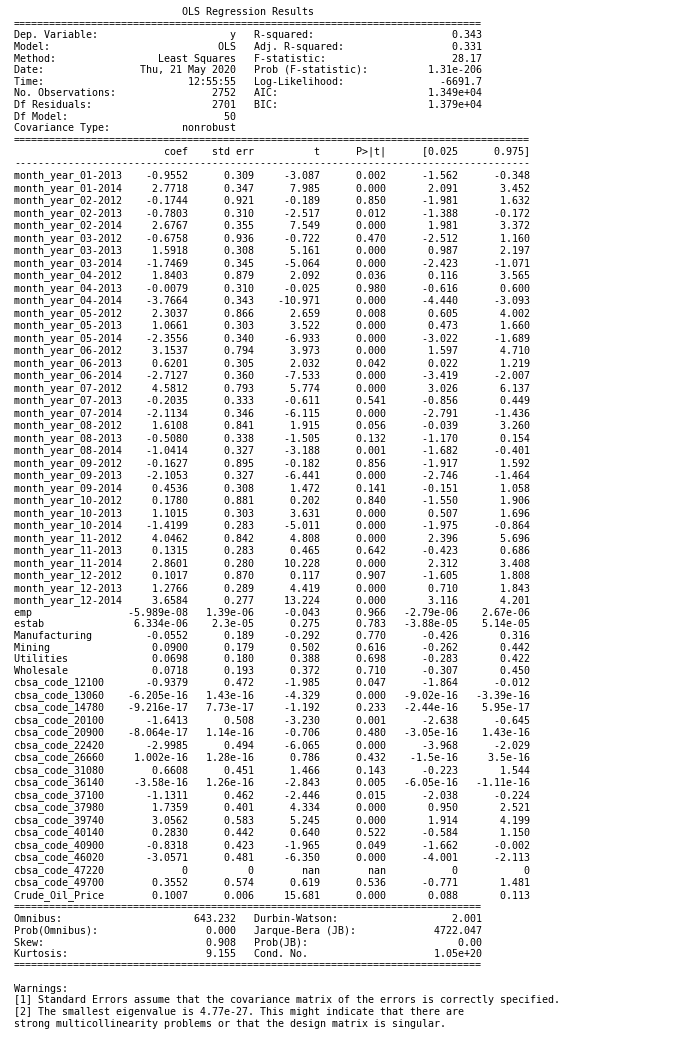

In [40]:
model = sm.OLS(y_train,X_train).fit()
predictions = model.predict(X_test)
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()

# Exporting PM2.5, Census, Oil Data to CSV to use in Tableau

In [41]:
export_file = pm25_census_oil[['Crude_Oil_Price','sector','sample','site','month_year','emp','estab','cbsa_code']]

export_file.to_csv('../data/pm25_census_oil.csv')


# Machine Learning
using the train/test split for OLS for ML

In [42]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [43]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [44]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

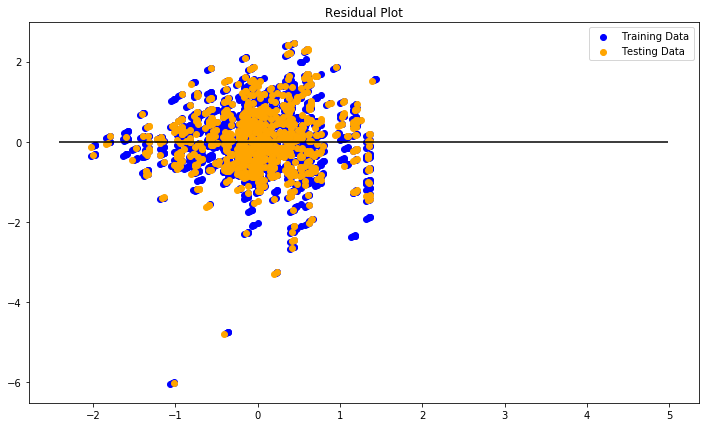

In [45]:
### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [46]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6859299444564035, R2: 0.2853008174050048


In [47]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6815070071513274, R2: 0.28990926131703143


In [48]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6847492438677263, R2: 0.28653103887650777


In [49]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6817590958798337, R2: 0.28964659949615457


# Redoing EPA Query for all MSAs in 2014
doing this to create averages of all MSAs and then compare to our selected MSAs

first grabbing all MSAs from crosswalk data

In [5]:
crosswalk1 = crosswalk[['CBSA Code']].rename(columns = {'CBSA Code':'CBSA'}).dropna().drop_duplicates()
crosswalk1.head()

,CBSA
0,10100
2,10140
3,10180
6,10220
7,10260


# Redoing API Call for all MSAs

In [6]:
response_sample = []
start = ["20140101"]
end = ["20140701"]
codes = crosswalk1['CBSA']


for index in range(len(start)):
    for each_msa in codes:
        try:
            url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
            response_sample.append(requests.get(url).json())
        except:
            print(f'MSA {each_msa} is not found')

In [7]:
response_sample1 = []
start = ["20140702"]
end = ["20141231"]
codes = crosswalk1['CBSA']

for index in range(len(start)):
    for each_msa in codes:
        try:
            url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
            response_sample.append(requests.get(url).json())
        except:
            print(f'MSA {each_msa} is not found')

In [8]:
print('-----------------------------------------')
print('There are '+ str(len(response_sample) + len(response_sample1)) + ' lists of lists from the API call')

-----------------------------------------
There are 1896 lists of lists from the API call


# Pulling Data and putting in list

In [9]:
time = []
date = []
cbsa_code = []
site = []
sample = []


for x in range(len(response_sample)):
# for x in range(0,32):
    try:
        for y in range(0,response_sample[x]['Header'][0]['rows']):
            time.append(response_sample[x]['Data'][y]['time_local'])
            date.append(response_sample[x]['Data'][y]['date_local'])
            cbsa_code.append(response_sample[x]['Data'][y]['cbsa_code'])
            site.append(response_sample[x]['Data'][y]['site_number'])
            sample.append(response_sample[x]['Data'][y]['sample_measurement'])
    except:
        print(f'CBSA {cbsa_code[y]} not found')

columns = ['time','date','cbsa_code','site','sample']
df_sample = pd.DataFrame(data = list(zip(time,date,cbsa_code,site,sample)), columns = columns)

df_sample.head()

CBSA 10500 not found
CBSA 10500 not found
CBSA 10500 not found
CBSA 10500 not found
CBSA 10500 not found
CBSA 10500 not found


,time,date,cbsa_code,site,sample
0,00:01,2014-01-02,10100,0003,13.7
1,00:01,2014-01-08,10100,0003,6.1
2,00:01,2014-01-14,10100,0003,3.6
3,00:01,2014-01-20,10100,0003,3.1
4,00:01,2014-01-26,10100,0003,2.4


# Converting date to DateTime
needed to group by month

In [10]:
df_sample['date'] = pd.to_datetime(df_sample.date,format = '%Y-%m')
print(df_sample.head(1))
print('---------------------------------------------------------')
print("There are "+ str(len(df_sample)) +" rows of PM2.5 data")

    time       date cbsa_code  site  sample
0  00:01 2014-01-02     10100  0003    13.7
---------------------------------------------------------
There are 2868125 rows of PM2.5 data


In [11]:
df_sample['month_year'] = df_sample['date'].dt.strftime('%m-%Y')
df_sample.head(1)

,time,date,cbsa_code,site,sample,month_year
0,00:01,2014-01-02,10100,0003,13.7,01-2014


# Grouping Hourly Data by day & Merging
PM2.5 data is organized by hour, but we need it on a daily level so it can map in with the AQI levels. First we do a groupby to get daily levels, then we need to remerge with the original data to get the categorical data back in (county, site, lat, lon)

In [12]:
df_sample1 = df_sample[['site','sample','month_year','cbsa_code']].groupby(['month_year','cbsa_code','site']).mean().reset_index().sort_values('month_year',ascending = False)
df_sample1.head()
len(df_sample1)
print(df_sample1.head(3))
print('-----------------------------------------')
print('There are '+ str(len(df_sample1)) + ' rows after grouping')

      month_year cbsa_code  site     sample
10010    12-2014     49740  8011   5.511440
9384     12-2014     19300  0010   7.188889
9461     12-2014     22800  0008  13.645455
-----------------------------------------
There are 10011 rows after grouping


# Exporting all CBSA EPA locations

In [14]:
df_sample1.to_csv('../data/pm25_all_cbsa_2014.csv')